In [49]:
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import NaN
from functions import * # import functions from the .py file

from pylab import rcParams
rcParams["figure.figsize"] = 16, 4

PAYLOADSIZE = 14

if PAYLOADSIZE % 2 != 0:
    print("Alarm! the payload size is not even.")
NUM_16RND = (PAYLOADSIZE-2)//2 # how many 16 bits random number included in each frame
MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq, the length of seq is 1B

## Log file

**For a fair comparison between groups, must follow the output format below**
<br>$\color{red}{\text{timestamp_rx }|\text{ len [hex] } \text{ seq [hex] } \text{ payload [hex] }|\text{rssi}}$
<br>$\text{ len [hex]}$ = payload length + 1 (seq. field length [1B])
<br>$\text{ payload [hex]}$ should start with the pseudo sequence number [2B], indicates the starting byte's position in the file.
***
*Example experiment file output for one frame with reciever timestamp xxxx, frame length, seq number and random payload, received signal strength.*
<br>15:17:18.394 |0f 46 bd f8 f7 ea 41 ac 1b be 05 a0 7f d2 09 d4 |  -91 CRC error
<br>$\color{red}{\text{delimiter for four variables is "|" and delimiter for the payload each byte is the space " ".}}$

In [50]:
import glob

clock = 125
experiments = pd.DataFrame()
experiments_df = dict()
logdir = "./log/"
for path in glob.glob(f"{logdir}*.txt"):
    filename = path.removeprefix(logdir)
    params = filename.removesuffix(".txt").split("_")
    data = {
        "filename": filename,
        "a": int(params[0]),
        "b": int(params[1]),
        "d1":int(params[2]), #cm
        "d2":int(params[3]), #cm
        "baudrate": int(params[4].replace('k', '000')),
        "receiver": params[5],
        "delta_fsk": clock/int(params[0]) - clock/int(params[1]),
        "file_delay_s": None,
        "bit_reliability": None,
        "dis_metric": None,
    }
    experiments_df[filename] = readfile(path)
    experiments = pd.concat([pd.DataFrame(data, index=[0]), experiments], ignore_index=True)
print(experiments)


                       filename   a   b  d1   d2  baudrate receiver  \
0   44_48_10_500_90k_cc1352.txt  44  48  10  500     90000   cc1352   
1   44_48_10_100_90k_cc1352.txt  44  48  10  100     90000   cc1352   
2   36_40_10_300_90k_cc1352.txt  36  40  10  300     90000   cc1352   
3   40_44_10_500_90k_cc1352.txt  40  44  10  500     90000   cc1352   
4   40_44_10_100_90k_cc1352.txt  40  44  10  100     90000   cc1352   
5   24_28_10_100_90k_cc1352.txt  24  28  10  100     90000   cc1352   
6   32_36_10_500_90k_cc1352.txt  32  36  10  500     90000   cc1352   
7   32_36_10_100_80k_cc1352.txt  32  36  10  100     80000   cc1352   
8   24_28_10_100_80k_cc1352.txt  24  28  10  100     80000   cc1352   
9   24_28_10_500_90k_cc1352.txt  24  28  10  500     90000   cc1352   
10  32_36_10_100_90k_cc1352.txt  32  36  10  100     90000   cc1352   
11  44_48_10_300_90k_cc1352.txt  44  48  10  300     90000   cc1352   
12  20_24_10_100_90k_cc1352.txt  20  24  10  100     90000   cc1352   
13  28

In [51]:
''' Calculate the file delay, bit reliability, and distance metric for each experiment'''

for idx, experiment in experiments.iterrows():
    print(f"Processing {experiment['filename']}")
    df = experiments_df[experiment["filename"]]
    
    # delete the corrupted packets (PAYLOADSIZE + 2B pesudo sequence number)
    df = df[df.payload.apply(lambda x: len(x)==((PAYLOADSIZE)*3-1))]
    df.reset_index(inplace=True)
    # replace the resettable seq number to unresettable, for the purpose of reliability calculation
    test = replace_seq(df.copy(), MAX_SEQ=256)
    test.rename(columns = {'seq':'old_seq', 'new_seq':'seq'}, inplace = True)

    # compute the file delay
    file_delay = df.time_rx[len(df) - 1] - df.time_rx[0]
    # convert the timedelta to s
    file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000
    experiments.loc[idx, "file_delay_s"] = file_delay_s

    # compute the BER for all received packets
    # return the in total ber for received file, error statistics and correct file content supposed to be transmitted
    ber, error, file_content = compute_ber(test, PACKET_LEN=NUM_16RND*2, MAX_SEQ=MAX_SEQ)
    bit_reliability = (1-ber)*100
    experiments.loc[idx, "bit_reliability"] = bit_reliability

    # record the distance
    dis_carrier_tag = experiment["d1"]/100 # cm -> m
    dis_tag_rx = experiment["d2"]/100 # cm -> m

    dis_metric = dis_carrier_tag**2*dis_tag_rx**2
    experiments.loc[idx, "dis_metric"] = dis_metric


Processing 44_48_10_500_90k_cc1352.txt
The total number of packets transmitted by the tag is 123.
Error statistics dataframe is:
     seq bit_error_tmp  bit_error
0      0          [47]         47
1      1          [41]         41
2      2          [38]         38
3      3          [50]         50
4      4          [46]         46
..   ...           ...        ...
118  118          [45]         45
119  119            []         96
120  120          [36]         36
121  121          [43]         43
122  122          [47]         47

[123 rows x 3 columns]
Processing 44_48_10_100_90k_cc1352.txt
The total number of packets transmitted by the tag is 1216.
Error statistics dataframe is:
       seq bit_error_tmp  bit_error
0       71           [1]          1
1       72           [0]          0
2       73           [0]          0
3       74          [10]         10
4       75           [0]          0
...    ...           ...        ...
1140  1211            []         96
1141  1212           

/var/folders/dc/wxy8s7vn5l54m2xpm7mlg6bh0000gn/T/ipykernel_1265/1042595717.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grp.sort_values(by=['delta_fsk'], inplace=True)


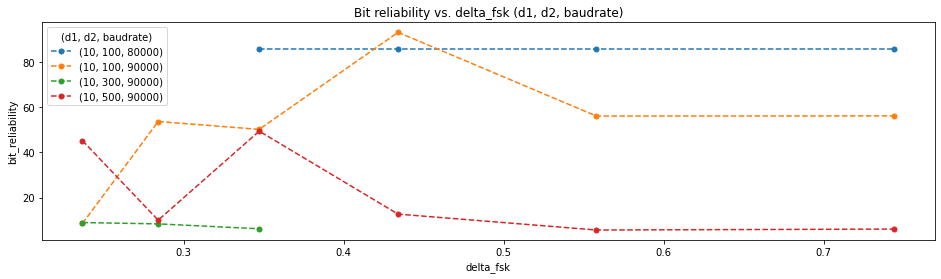

In [52]:
fig, ax = plt.subplots()

# Plot the fig for each baudrate and distance
for key, grp in experiments.groupby(['d1','d2','baudrate']):
    ## filter out the delta_fsk >= 1
    grp = grp.loc[grp["delta_fsk"] < 1]
    grp.sort_values(by=['delta_fsk'], inplace=True)
    ax = plt.plot(grp['delta_fsk'], grp['bit_reliability'], label=key, marker='o', linestyle='--', markersize=5)

plt.title('Bit reliability vs. delta_fsk (d1, d2, baudrate)')
plt.xlabel('delta_fsk')
plt.ylabel('bit_reliability')
plt.legend(title='(d1, d2, baudrate)')
plt.show()

# Radarplot

**Please pay attention to the unit**
<br> <font color='red'>Time</font>: use second as unit
<br> <font color='red'>Reliability</font>: use the percent as unit
<br> <font color='red'>Distance</font>: use meter as unit
<br>**Metics = [Time(s), Reliability(%), Distance(m)]**
<br> <font color='red'>Always keep the reference in your plot.</font>
<br> Tips: for ploting, time metric uses $\frac{1}{Time}*1000$ as the time metric, the higher the value the better the system performance

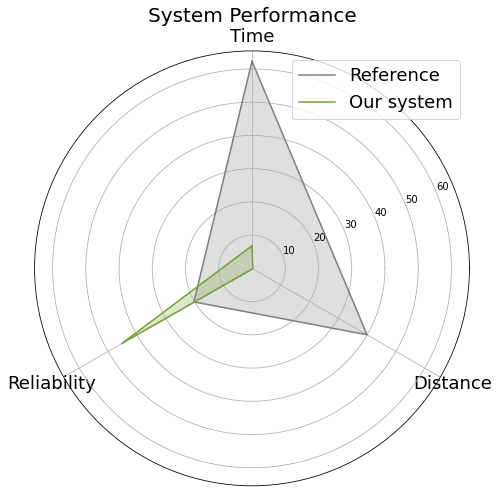

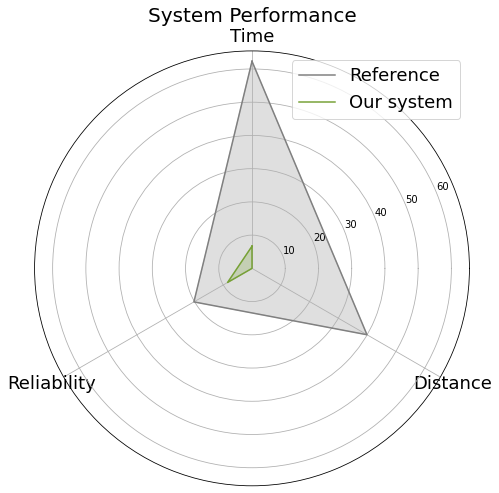

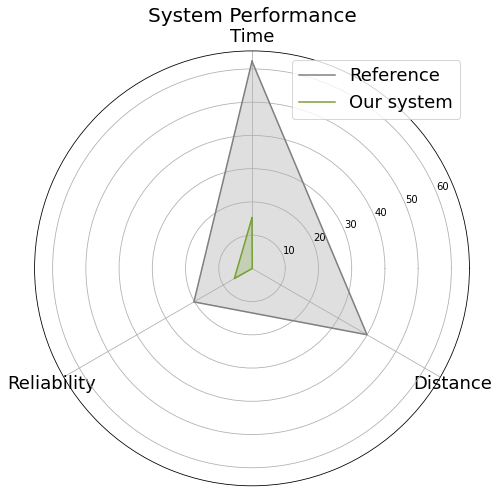

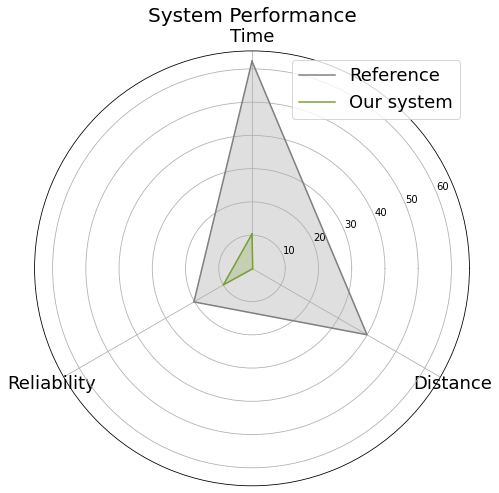

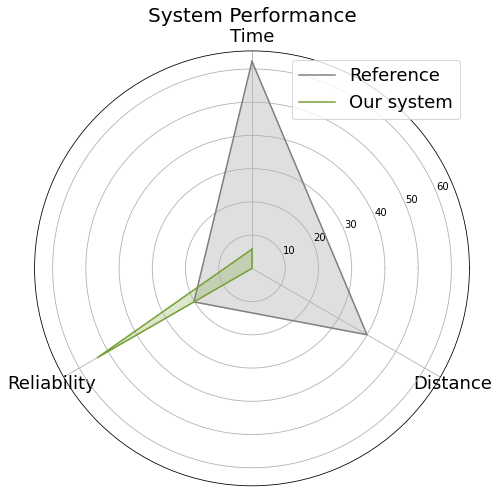

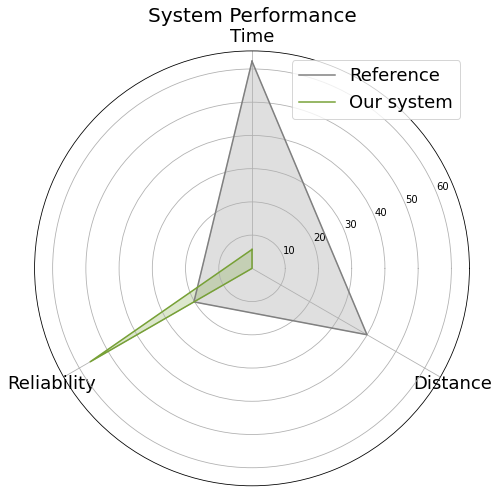

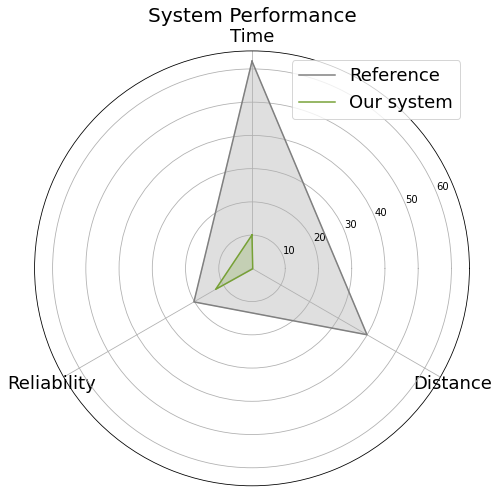

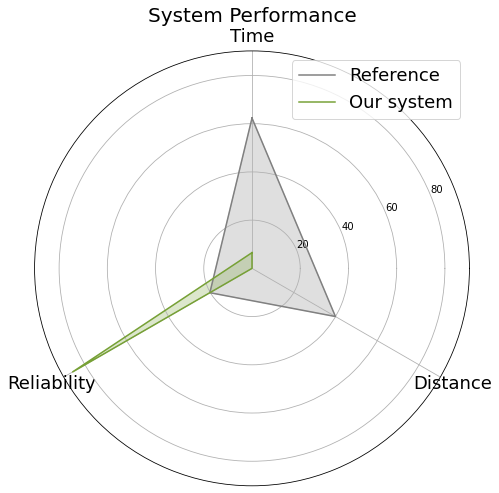

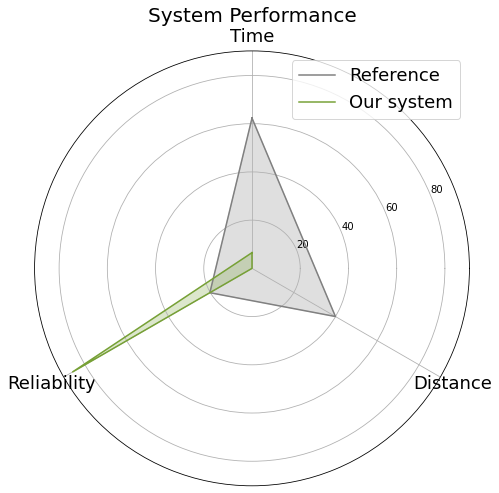

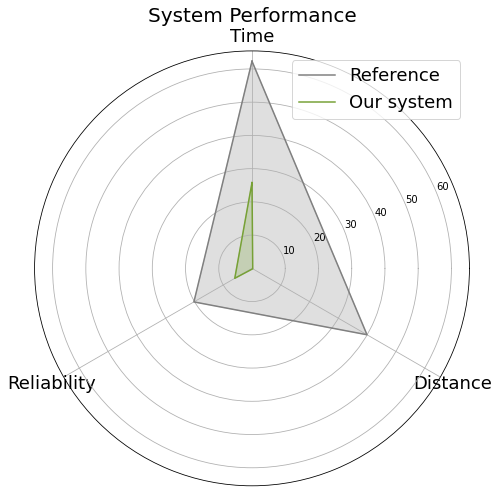

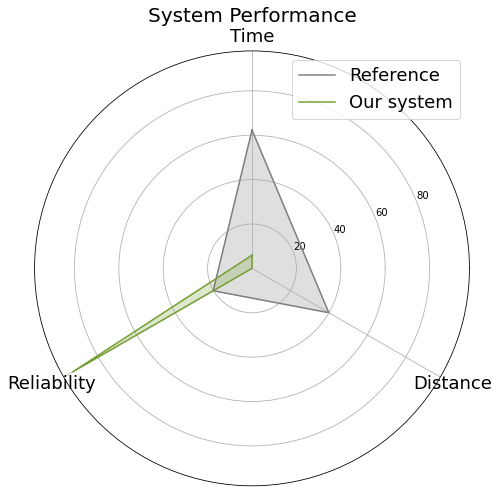

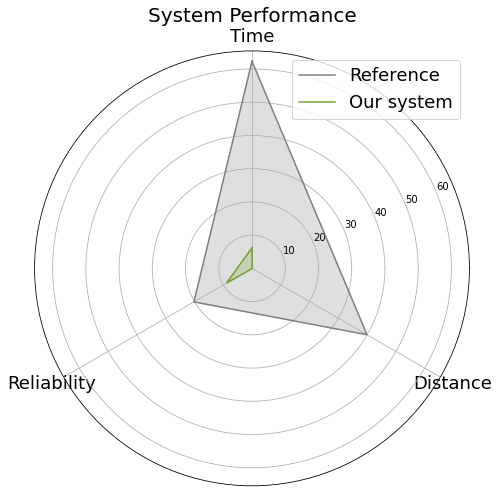

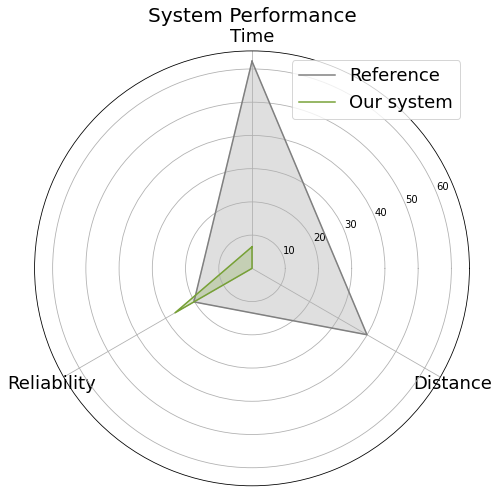

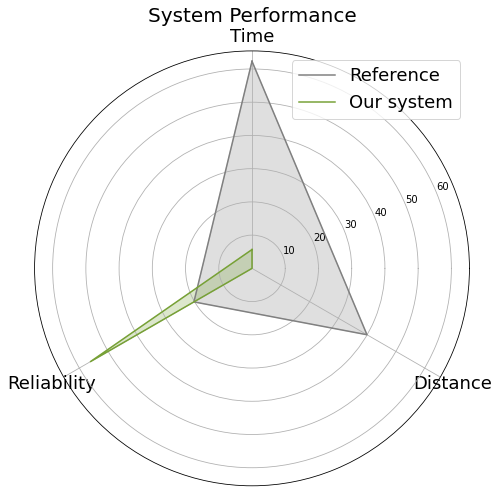

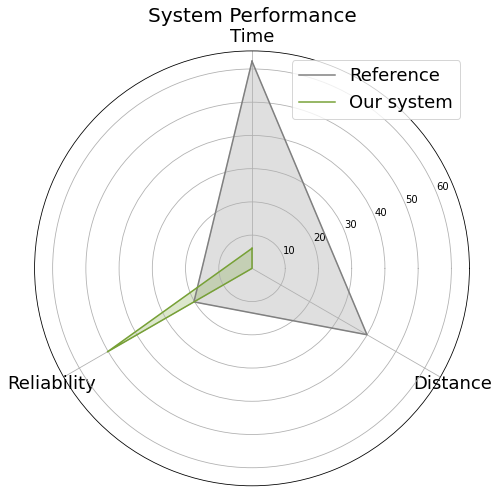

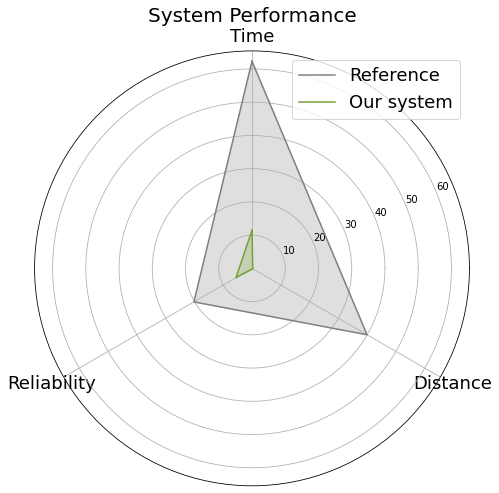

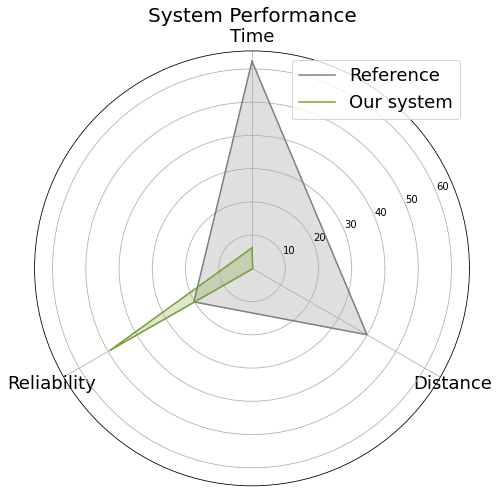

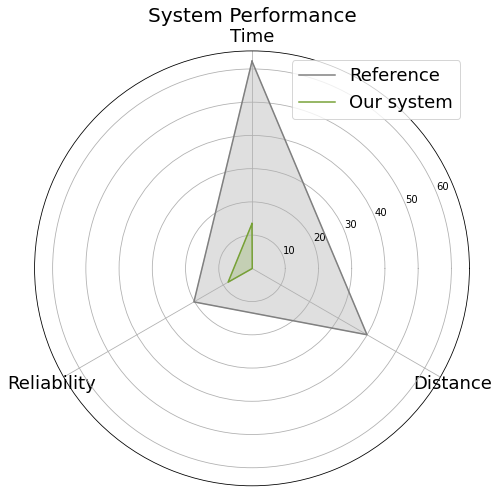

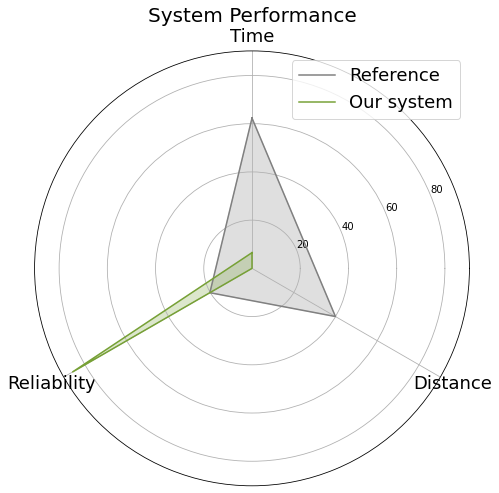

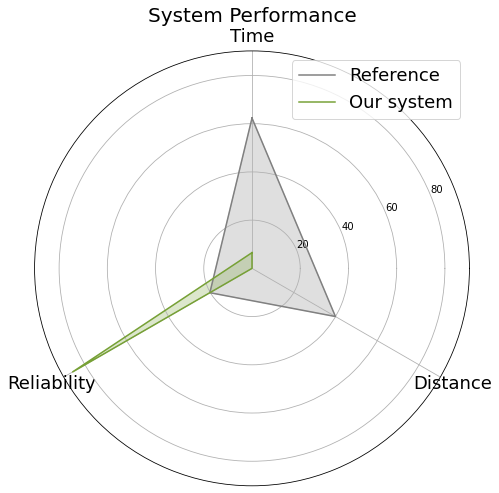

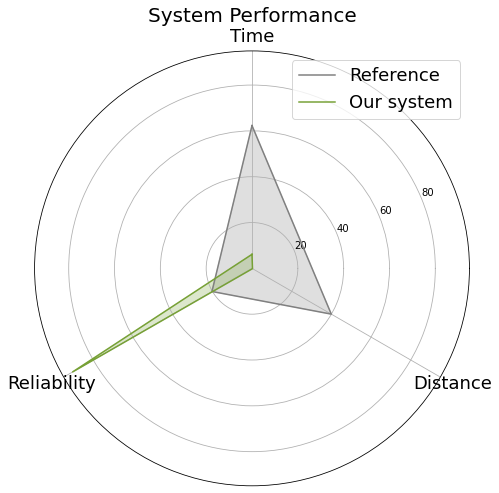

In [53]:
for idx, experiment in experiments.iterrows():
    metrics = [experiment["file_delay_s"], experiment["bit_reliability"], experiment["dis_metric"]]
    radar_plot(metrics)